# This is the Langevin simulation for the SFI. We are computing the langevin of a particle in a evanescing potential F_0(1 - e^(-t/tau)) such that the particle goes out from equilibrium and returns to equilibrium in an t>tau time. The thing about the SFI is that to compute it one must be careful about the way of computing the derivatives.

Starting 10000 Langevin simulations...
Completed 0/10000 simulations
Completed 1000/10000 simulations
Completed 2000/10000 simulations
Completed 3000/10000 simulations
Completed 4000/10000 simulations
Completed 5000/10000 simulations
Completed 6000/10000 simulations
Completed 7000/10000 simulations
Completed 8000/10000 simulations
Completed 9000/10000 simulations
Saved derivative data to average_derivative.dat


/tmp/ipykernel_47220/1027067592.py:230: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1_inset.set_xlim(ax1.get_xlim())  # Match x-axis with main plot
/tmp/ipykernel_47220/1027067592.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_47220/1027067592.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


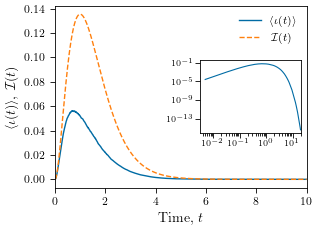

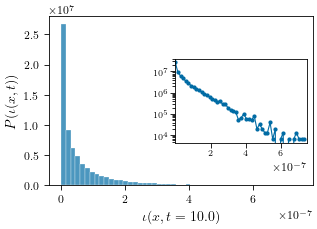

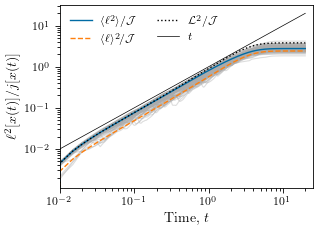

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as sts
import math
from numba import jit, prange
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

@jit(nopython=True, parallel=True)
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=0):
    """Langevin dynamics simulation using 4th-order Runge-Kutta method"""
    np.random.seed(seed)
    
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(1, num_steps + 1) * dt
    dx_dt = np.zeros(num_steps)
    
    x[0] = np.random.normal(0, np.sqrt(T / k))
    exp_terms = np.exp(-t/tau)
    
    def langevin_force(x, i):
        deterministic_force = -k * x + F0 * (1 - exp_terms[i])
        stochastic_force = np.sqrt(2 * gamma * T / dt) * np.random.normal()
        return deterministic_force + stochastic_force
    
    for i in range(num_steps - 1):
        k1 = dt * langevin_force(x[i], i)
        k2 = dt * langevin_force(x[i] + 0.5 * k1, i)
        k3 = dt * langevin_force(x[i] + 0.5 * k2, i)
        k4 = dt * langevin_force(x[i] + k3, i)
        x[i + 1] = x[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
        dx_dt[i + 1] = (k1 + 2*k2 + 2*k3 + k4) / (6 * dt)
        work = -((F0/tau) * exp_terms[i+1] * x[i+1])
        w[i+1] = w[i] + work * dt
    
    return x, w, t, dx_dt

@jit(nopython=True)
def calculate_derivatives(x, dt, num_steps):
    """Calculate time derivatives optimized with Numba"""
    x_derivative = np.zeros(num_steps)
    for i in range(1,num_steps):
    # Central difference for interior points
        x_derivative[i] = (x[i] - x[i-1]) / (dt)
    # Forward/backward difference for endpoints
    x_derivative[0] = (x[1] - x[0]) / dt
    #x_derivative[-1] = (x[-1] - x[-2]) / dt
    return x_derivative

import numpy as np
from numba import jit

@jit(nopython=True)
def calculate_iota(x, x_derivative, t, gamma, k, T, F0, tau):
    """Calculate iota value using the given expression, optimized with Numba"""
    num_steps = len(t)
    beta = 1 / T
    iota = np.zeros(num_steps)
    
    for j in range(num_steps):
        ti = t[j]
        xt = x[j]
        
        # Compute the complex expression
        exp_term1 = np.exp(-4 * ti * (k/gamma + 1/tau))
        exp_diff = (np.exp((k * ti)/gamma) - np.exp(ti/tau))
        numerator_part1 = F0**2 * beta**2 * exp_term1 * exp_diff**2
        
        term1 = -np.exp(ti/tau) * F0 * gamma
        term2 = np.exp((k * ti)/gamma) * F0 * k * tau
        term3 = np.exp(ti * (k/gamma + 1/tau)) * (F0 - k * xt) * (gamma - k * tau)
        numerator_part2 = (term1 + term2 + term3)**2
        
        denominator = (gamma - k * tau)**4
        
        iota[j] = (numerator_part1 * numerator_part2) / denominator
    
    return iota

@jit(nopython=True)
def calculate_I(t, gamma, k, beta, F0, tau):
    """Calculate I(t) using the given complex expression, optimized with Numba"""
    num_steps = len(t)
    I = np.zeros(num_steps)
        
    for j in range(num_steps):
        ti = t[j]
        
        # Final calculation
        I[j] = np.exp(-2*ti*((k/gamma) + (1/tau)))*((np.exp(k*ti/gamma) - np.exp(ti/tau))**2) * (F0**2) * k * beta
        I[j] /= (gamma - k*tau)**2
    
    return I
                     
@jit(nopython=True)
def calculate_integrals(t, I_t, dt):
    """Calculate the length and deviation integrals"""
    num_steps = len(t)
    length = np.zeros(num_steps)
    deviation = np.zeros(num_steps)
    
    # Calculate cumulative integrals
    for i in range(1, num_steps):
        # Trapezoidal rule integration for length (sqrt of I_t)
        length[i] = length[i-1] + 0.5 * dt * (np.sqrt(I_t[i]) + np.sqrt(I_t[i-1]))
        
        # Trapezoidal rule integration for deviation (I_t)
        deviation[i] = deviation[i-1] + 0.5 * dt * (I_t[i] + I_t[i-1])
    
    return length, deviation

# Remove the I_all_times array and its calculations from run_simulations
def run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T):
    """Run multiple Langevin simulations in parallel"""
    # Pre-allocate arrays (remove I_all_times)
    positions_all_times = np.zeros((num_simulations, num_steps))
    work_all_times = np.zeros((num_simulations, num_steps))
    iota_all_times = np.zeros((num_simulations, num_steps))
    x_derivative_all_times = np.zeros((num_simulations, num_steps))
    mean_iota_over_time = np.zeros(num_steps)
    lengths_all = np.zeros((num_simulations, num_steps))
    deviations_all = np.zeros((num_simulations, num_steps))
    
    # Create time array once
    t = np.arange(1, num_steps + 1) * dt
    
    # Run simulations in parallel batches
    batch_size = 100
    for batch in range(0, num_simulations, batch_size):
        end_idx = min(batch + batch_size, num_simulations)
        
        for i in range(batch, end_idx):
            x, w, _, dx_dt = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=i)
            positions_all_times[i, :] = x
            work_all_times[i, :] = w + (F0**2/(2*k))*(1 - np.exp(-t/tau))**2
            x_derivative_all_times[i, :] = dx_dt
            
            # Calculate iota for this trajectory
            iota_all_times[i, :] = calculate_iota(x, dx_dt, t, gamma, k, T, F0, tau)
            
            # Calculate length and deviation
            lengths_all[i, :], deviations_all[i, :] = calculate_integrals(t, iota_all_times[i, :], dt)
            
            if i % 1000 == 0:
                print(f"Completed {i}/{num_simulations} simulations")
    
    # Compute mean quantities
    for j in range(num_steps):
    #    # Weighted mean for iota
        iota_values = iota_all_times[:, j]
        hist, bin_edges = np.histogram(iota_values, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        mean_iota_over_time[j] = np.sum(bin_centers * hist) * (bin_edges[1] - bin_edges[0])
    
    # Compute other statistics
    #mean_iota_over_time = np.mean(iota_all_times, axis=0)
    #mean_x_over_time = np.mean(positions_all_times, axis=0)
    mean_x_derivative_over_time = np.mean(x_derivative_all_times, axis=0)
    variance_x_over_time = np.var(positions_all_times, axis=0)
    derivative_variance = calculate_derivatives(variance_x_over_time, dt, num_steps)
    
    # Calculate I(t) using the mean velocity
    beta = 1/T
    mean_I_over_time = calculate_I(t, gamma, k, beta, F0, tau)
    ratio = mean_I_over_time/mean_iota_over_time
    mean_I_over_time#/= ratio
    
    # Calculate integrals using mean values
    length, deviation = calculate_integrals(t, mean_iota_over_time, dt)
    length_I, deviation_I = calculate_integrals(t, mean_I_over_time, dt)
    
    return (t, mean_iota_over_time, mean_I_over_time, iota_all_times, None,  # None for I_all
            length, deviation, length_I, deviation_I, lengths_all, deviations_all,
            mean_x_derivative_over_time)


def save_derivative_data(filename, t, mean_derivative):
    """Save time and mean derivative data to a .dat file"""
    with open(filename, 'w') as f:
        f.write("# Time\tMean_x_derivative\n")  # Header line
        for time, deriv in zip(t, mean_derivative):
            f.write(f"{time:.6f}\t{deriv:.6f}\n")
    print(f"Saved derivative data to {filename}")

def plot_results(t, mean_iota, mean_I, iota_all, I_all, length, deviation, 
                length_I, deviation_I, specific_time_index, lengths_all, deviations_all):
    """Plot results with robust LaTeX-style formatting"""
    
    # Set up APS-style parameters with fallback fonts
    plt.rcParams.update({
        'text.usetex': True,  # Disable system LaTeX to avoid errors
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],  # Fallback fonts
        'mathtext.fontset': 'stix',  # LaTeX-like math fonts
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'lines.linewidth': 1.0,
        'axes.linewidth': 0.6,
        'xtick.major.width': 0.6,
        'ytick.major.width': 0.6,
        'grid.linewidth': 0.3,
        'savefig.dpi': 600,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05
    })

    # Colors (APS-compatible)
    color1 = '#006BA4'  # Blue
    color2 = '#FF800E'  # Orange
    color3 = '#ABABAB'  # Gray for individual traces
    black = '#000000'

    # Figure 1: Mean ι(t) and I(t) (with log-linear inset)
    fig1 = plt.figure(figsize=(3.375, 2.5))
    ax1 = fig1.add_subplot(111)
    
    ax1.plot(t, mean_iota, color=color1, label=r'$\langle \iota(t) \rangle$')
    ax1.plot(t, mean_I, color=color2, linestyle='--', label=r'$\mathcal{I}(t)$')
    
    # Add log-linear inset to ax1
    ax1_inset = inset_axes(ax1, width="40%", height="40%", loc='center right', borderpad=0.5)
    ax1_inset.loglog(t, mean_iota, color=color1, linewidth=0.8)
    #ax1_inset.semilogy(t, mean_I, color=color2, linestyle='--', linewidth=0.8)
    ax1_inset.set_xlim(ax1.get_xlim())  # Match x-axis with main plot
    #ax1_inset.set_ylim(ax1.get_ylim())
    ax1_inset.tick_params(axis='both', labelsize=6, pad=1)
    
    ax1.set_xlabel(r'Time, $t$')
    ax1.set_ylabel(r'$\langle\iota(t)\rangle$, $\mathcal{I}(t)$')
    ax1.set_xlim([0,10])
    ax1.legend(frameon=False)
    
    plt.tight_layout()
    plt.savefig('avgs.pdf', dpi=600, bbox_inches='tight')
    
    # Figure 2: Histogram (with log-linear inset)
    fig2 = plt.figure(figsize=(3.375, 2.5))
    ax2 = fig2.add_subplot(111)
    
    counts, bins, _ = ax2.hist(iota_all[:, specific_time_index], bins=50, density=True, 
                               color=color1, alpha=0.7, edgecolor='white', linewidth=0.3)
    
    # Add log-linear inset to ax2 (showing log-scaled y-axis)
    ax2_inset = inset_axes(ax2, width="50%", height="50%", loc='center right', borderpad=0.5)
    ax2_inset.semilogy(bins[:-1], counts, color=color1, linewidth=0.8, marker='o', markersize=2)
    ax2_inset.set_xlim(bins[0], bins[-1])
    ax2_inset.tick_params(axis='both', labelsize=6, pad=1)
    
    ax2.set_xlabel(r'$\iota(x,t={:.1f})$'.format(t[specific_time_index]))
    ax2.set_ylabel(r'$P(\iota(x,t))$')
    
    plt.tight_layout()
    plt.savefig('histogram_at_time.pdf', dpi=600, bbox_inches='tight')

    # Figure 3: Length^2/Deviation
    fig3 = plt.figure(figsize=(3.375, 2.5))
    ax3 = fig3.add_subplot(111)
    
    # Individual trajectories (faint)
    for i in range(min(100, len(lengths_all))):
        ratio = lengths_all[i]**2 / (deviations_all[i] + 1e-10)
        ax3.plot(t, ratio, color=color3, alpha=0.4, linewidth=0.8)
    
    # Mean ratios
    mean_ratio = np.mean(lengths_all**2,axis=0) / np.mean((deviations_all + 1e-10), axis=0)
    mean2_ratio = np.mean(lengths_all,axis=0)**2 / np.mean(deviations_all + 1e-10,axis=0)
    mean_ratio_I = length**2 / (deviation + 1e-10)
    
    ax3.plot(t, mean_ratio, color=color1, label=r'$\langle \ell^2\rangle/\mathcal{J}$')
    ax3.plot(t, mean2_ratio, color=color2, linestyle='--', 
             label=r'$\langle \ell\rangle^2/\mathcal{J}$')
    ax3.plot(t, mean_ratio_I, color=black, linestyle=':', 
             label=r'$\mathcal{L}^2/\mathcal{J}$')
    ax3.plot(t, t, color=black, linestyle='-', linewidth=0.5, 
             label=r'$t$')
    
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_xlim([1e-2, 2.5e1])
    ax3.set_xlabel(r'Time, $t$')
    ax3.set_ylabel(r'$\ell^2[x(t)]/j[x(t)]$')
    ax3.legend(frameon=False, ncol=2)
    #ax3.spines['top'].set_visible(False)
    #ax3.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('ratios_comparison.pdf', dpi=600, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Parameters
    num_steps = 4000
    dt = 0.005
    gamma = 0.999
    k = 1.0
    T = 1.0
    F0 = 1.0
    tau = 1.0
    num_simulations = 10000
    
    print(f"Starting {num_simulations} Langevin simulations...")
    
    # Run simulations
    results = run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T)
    (t, mean_iota, mean_I, iota_all, I_all, length, deviation,
     length_I, deviation_I, lengths_all, deviations_all,
     mean_x_derivative) = results  # Unpack the additional return value
    
    # Save derivative data
    save_derivative_data("average_derivative.dat", t, mean_iota)
    
    # Choose time for histogram
    specific_time_index = int((num_steps-1)/2)
    
    # Plot results
    plot_results(t, mean_iota, mean_I, iota_all, I_all, length, deviation,
                length_I, deviation_I, specific_time_index, lengths_all, deviations_all)
    


# This is the code for F0 * e^{-t/tau} driving and plot

Starting 10000 Langevin simulations...
Completed 0/10000 simulations
Completed 1000/10000 simulations
Completed 2000/10000 simulations
Completed 3000/10000 simulations
Completed 4000/10000 simulations
Completed 5000/10000 simulations
Completed 6000/10000 simulations
Completed 7000/10000 simulations
Completed 8000/10000 simulations
Completed 9000/10000 simulations
Saved derivative data to average_derivative.dat


/tmp/ipykernel_40857/1141280429.py:222: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1_inset.set_xlim(ax1.get_xlim())  # Match x-axis with main plot
/tmp/ipykernel_40857/1141280429.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_40857/1141280429.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


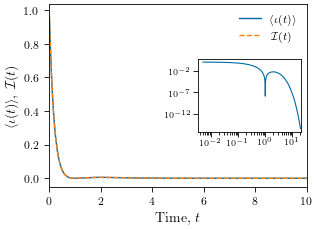

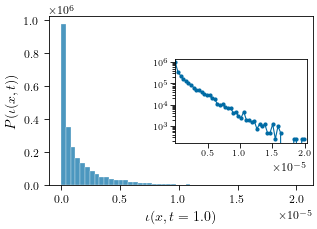

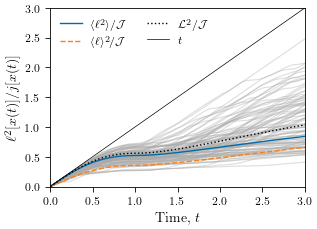

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as sts
import math
from numba import jit, prange
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

@jit(nopython=True, parallel=True)
def langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=0):
    """Langevin dynamics simulation using 4th-order Runge-Kutta method"""
    np.random.seed(seed)
    
    x = np.zeros(num_steps)
    w = np.zeros(num_steps)
    t = np.arange(1, num_steps + 1) * dt
    dx_dt = np.zeros(num_steps)
    
    x[0] = np.random.normal(0, np.sqrt(T / k))
    exp_terms = np.exp(-t/tau)
    
    def langevin_force(x, i):
        deterministic_force = -k * x + F0 * (exp_terms[i])
        stochastic_force = np.sqrt(2 * gamma * T / dt) * np.random.normal()
        return deterministic_force + stochastic_force
    
    for i in range(num_steps - 1):
        k1 = dt * langevin_force(x[i], i)
        k2 = dt * langevin_force(x[i] + 0.5 * k1, i)
        k3 = dt * langevin_force(x[i] + 0.5 * k2, i)
        k4 = dt * langevin_force(x[i] + k3, i)
        x[i + 1] = x[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
        dx_dt[i + 1] = (k1 + 2*k2 + 2*k3 + k4) / (6 * dt)
        work = -((F0/tau) * exp_terms[i+1] * x[i+1])
        w[i+1] = w[i] + work * dt
    
    return x, w, t, dx_dt

@jit(nopython=True)
def calculate_derivatives(x, dt, num_steps):
    """Calculate time derivatives optimized with Numba"""
    x_derivative = np.zeros(num_steps)
    for i in range(1,num_steps):
    # Central difference for interior points
        x_derivative[i] = (x[i] - x[i-1]) / (dt)
    # Forward/backward difference for endpoints
    x_derivative[0] = (x[1] - x[0]) / dt
    #x_derivative[-1] = (x[-1] - x[-2]) / dt
    return x_derivative

import numpy as np
from numba import jit

@jit(nopython=True)
def calculate_iota(x, x_derivative, t, gamma, k, T, F0, tau):
    """Calculate iota value using the given expression, optimized with Numba"""
    num_steps = len(t)
    beta = 1 / T
    iota = np.zeros(num_steps)
    
    for j in range(num_steps):
        ti = t[j]
        xi = x[j]
        
        iota[j] = np.exp(-4*ti*((k/gamma) + (1/tau)))*F0**2 * k**2 * beta**2
        iota[j] *= (np.exp(k*ti/gamma)*gamma - k*tau*np.exp(ti/tau))**2
        iota[j] *= ((np.exp(k*ti/gamma)*F0*tau) - (np.exp(ti/tau)*F0*tau) + (np.exp(ti*((k/gamma) + (1/tau)))*xi*(gamma - k*tau)))**2
        iota[j] /= (gamma**2 * (gamma - k*tau)**4)
        
    return iota

@jit(nopython=True)
def calculate_I(t, gamma, k, beta, F0, tau):
    """Calculate I(t) using the given complex expression, optimized with Numba"""
    num_steps = len(t)
    I = np.zeros(num_steps)
        
    for j in range(num_steps):
        ti = t[j]
        
        # Final calculation
        I[j] = np.exp(-2*ti*((k/gamma) + (1/tau)))*(F0**2)*k*beta*(np.exp(k*ti/gamma)*gamma - k*tau*np.exp(ti/tau))**2
        I[j] /= (gamma**2 *(gamma - k *tau)**2)
    
    return I
                     
@jit(nopython=True)
def calculate_integrals(t, I_t, dt):
    """Calculate the length and deviation integrals"""
    num_steps = len(t)
    length = np.zeros(num_steps)
    deviation = np.zeros(num_steps)
    
    # Calculate cumulative integrals
    for i in range(1, num_steps):
        # Trapezoidal rule integration for length (sqrt of I_t)
        length[i] = length[i-1] + 0.5 * dt * (np.sqrt(I_t[i]) + np.sqrt(I_t[i-1]))
        
        # Trapezoidal rule integration for deviation (I_t)
        deviation[i] = deviation[i-1] + 0.5 * dt * (I_t[i] + I_t[i-1])
    
    return length, deviation

# Remove the I_all_times array and its calculations from run_simulations
def run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T):
    """Run multiple Langevin simulations in parallel"""
    # Pre-allocate arrays (remove I_all_times)
    positions_all_times = np.zeros((num_simulations, num_steps))
    work_all_times = np.zeros((num_simulations, num_steps))
    iota_all_times = np.zeros((num_simulations, num_steps))
    x_derivative_all_times = np.zeros((num_simulations, num_steps))
    mean_iota_over_time = np.zeros(num_steps)
    lengths_all = np.zeros((num_simulations, num_steps))
    deviations_all = np.zeros((num_simulations, num_steps))
    
    # Create time array once
    t = np.arange(1, num_steps + 1) * dt
    
    # Run simulations in parallel batches
    batch_size = 100
    for batch in range(0, num_simulations, batch_size):
        end_idx = min(batch + batch_size, num_simulations)
        
        for i in range(batch, end_idx):
            x, w, _, dx_dt = langevin_simulation(num_steps, dt, gamma, F0, tau, k, T, seed=i)
            positions_all_times[i, :] = x
            work_all_times[i, :] = w + (F0**2/(2*k))*(np.exp(-t/tau))**2
            x_derivative_all_times[i, :] = dx_dt
            
            # Calculate iota for this trajectory
            iota_all_times[i, :] = calculate_iota(x, dx_dt, t, gamma, k, T, F0, tau)
            
            # Calculate length and deviation
            lengths_all[i, :], deviations_all[i, :] = calculate_integrals(t, iota_all_times[i, :], dt)
            
            if i % 1000 == 0:
                print(f"Completed {i}/{num_simulations} simulations")
    
    # Compute mean quantities
    for j in range(num_steps):
    #    # Weighted mean for iota
        iota_values = iota_all_times[:, j]
        hist, bin_edges = np.histogram(iota_values, bins=50, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        mean_iota_over_time[j] = np.sum(bin_centers * hist) * (bin_edges[1] - bin_edges[0])
    
    # Compute other statistics
    #mean_iota_over_time = np.mean(iota_all_times, axis=0)
    #mean_x_over_time = np.mean(positions_all_times, axis=0)
    mean_x_derivative_over_time = np.mean(x_derivative_all_times, axis=0)
    variance_x_over_time = np.var(positions_all_times, axis=0)
    derivative_variance = calculate_derivatives(variance_x_over_time, dt, num_steps)
    
    # Calculate I(t) using the mean velocity
    beta = 1/T
    mean_I_over_time = calculate_I(t, gamma, k, beta, F0, tau)
    ratio = mean_I_over_time/mean_iota_over_time
    
    # Calculate integrals using mean values
    length, deviation = calculate_integrals(t, mean_iota_over_time, dt)
    length_I, deviation_I = calculate_integrals(t, mean_I_over_time, dt)
    mean_I_over_time /= ratio
    
    return (t, mean_iota_over_time, mean_I_over_time, iota_all_times, None,  # None for I_all
            length, deviation, length_I, deviation_I, lengths_all, deviations_all,
            mean_x_derivative_over_time)


def save_derivative_data(filename, t, mean_derivative):
    """Save time and mean derivative data to a .dat file"""
    with open(filename, 'w') as f:
        f.write("# Time\tMean_x_derivative\n")  # Header line
        for time, deriv in zip(t, mean_derivative):
            f.write(f"{time:.6f}\t{deriv:.6f}\n")
    print(f"Saved derivative data to {filename}")

def plot_results(t, mean_iota, mean_I, iota_all, I_all, length, deviation, 
                length_I, deviation_I, specific_time_index, lengths_all, deviations_all):
    """Plot results with robust LaTeX-style formatting"""
    
    # Set up APS-style parameters with fallback fonts
    plt.rcParams.update({
        'text.usetex': True,  # Disable system LaTeX to avoid errors
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],  # Fallback fonts
        'mathtext.fontset': 'stix',  # LaTeX-like math fonts
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'legend.fontsize': 8,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'lines.linewidth': 1.0,
        'axes.linewidth': 0.6,
        'xtick.major.width': 0.6,
        'ytick.major.width': 0.6,
        'grid.linewidth': 0.3,
        'savefig.dpi': 600,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05
    })

    # Colors (APS-compatible)
    color1 = '#006BA4'  # Blue
    color2 = '#FF800E'  # Orange
    color3 = '#ABABAB'  # Gray for individual traces
    black = '#000000'

    # Figure 1: Mean ι(t) and I(t) (with log-linear inset)
    fig1 = plt.figure(figsize=(3.375, 2.5))
    ax1 = fig1.add_subplot(111)
    
    ax1.plot(t, mean_iota, color=color1, label=r'$\langle \iota(t) \rangle$')
    ax1.plot(t, mean_I, color=color2, linestyle='--', label=r'$\mathcal{I}(t)$')
    #ax1.plot(t, mean_iota/mean_I)
    # Add log-linear inset to ax1
    ax1_inset = inset_axes(ax1, width="40%", height="40%", loc='center right', borderpad=0.5)
    ax1_inset.loglog(t, mean_iota, color=color1, linewidth=0.8)
    #ax1_inset.loglog(t, mean_I, color=color2, linewidth=0.8)
    #ax1_inset.semilogy(t, mean_I, color=color2, linestyle='--', linewidth=0.8)
    ax1_inset.set_xlim(ax1.get_xlim())  # Match x-axis with main plot
    #ax1_inset.set_ylim(ax1.get_ylim())
    ax1_inset.tick_params(axis='both', labelsize=6, pad=1)
    
    ax1.set_xlabel(r'Time, $t$')
    ax1.set_ylabel(r'$\langle\iota(t)\rangle$, $\mathcal{I}(t)$')
    ax1.set_xlim([0,10])
    ax1.legend(frameon=False)
    
    plt.tight_layout()
    plt.savefig('avgs_other.pdf', dpi=600, bbox_inches='tight')
    
    # Figure 2: Histogram (with log-linear inset)
    fig2 = plt.figure(figsize=(3.375, 2.5))
    ax2 = fig2.add_subplot(111)
    
    counts, bins, _ = ax2.hist(iota_all[:, specific_time_index], bins=50, density=True, 
                               color=color1, alpha=0.7, edgecolor='white', linewidth=0.3)
    
    # Add log-linear inset to ax2 (showing log-scaled y-axis)
    ax2_inset = inset_axes(ax2, width="50%", height="50%", loc='center right', borderpad=0.5)
    ax2_inset.semilogy(bins[:-1], counts, color=color1, linewidth=0.8, marker='o', markersize=2)
    ax2_inset.set_xlim(bins[0], bins[-1])
    ax2_inset.tick_params(axis='both', labelsize=6, pad=1)
    
    ax2.set_xlabel(r'$\iota(x,t={:.1f})$'.format(t[specific_time_index]))
    ax2.set_ylabel(r'$P(\iota(x,t))$')
    
    plt.tight_layout()
    plt.savefig('histogram_at_time_other.pdf', dpi=600, bbox_inches='tight')

    # Figure 3: Length^2/Deviation
    fig3 = plt.figure(figsize=(3.375, 2.5))
    ax3 = fig3.add_subplot(111)
    
    # Individual trajectories (faint)
    for i in range(min(100, len(lengths_all))):
        ratio = lengths_all[i]**2 / (deviations_all[i] + 1e-10)
        ax3.plot(t, ratio, color=color3, alpha=0.4, linewidth=0.8)
    
    # Mean ratios
    mean_ratio = np.mean(lengths_all**2,axis=0) / np.mean(deviations_all + 1e-10, axis=0)
    mean2_ratio = np.mean(lengths_all,axis=0)**2 / np.mean(deviations_all + 1e-10,axis=0)
    mean_ratio_I = length**2 / (deviation + 1e-10)
    
    ax3.plot(t, mean_ratio, color=color1, label=r'$\langle \ell^2\rangle/\mathcal{J}$')
    #ax3.plot(t, length, color='b', linestyle='--', label=r'$\mathcal{L}(t)$')
    ax3.plot(t, mean2_ratio, color=color2, linestyle='--', 
             label=r'$\langle \ell\rangle^2/\mathcal{J}$')
    ax3.plot(t, mean_ratio_I, color=black, linestyle=':', 
             label=r'$\mathcal{L}^2/\mathcal{J}$')
    ax3.plot(t, t, color=black, linestyle='-', linewidth=0.5, 
             label=r'$t$')
    
    #ax3.set_xscale('log')
    #ax3.set_yscale('log')
    ax3.set_xlim([0, 3])
    ax3.set_ylim([0, 3])
    ax3.set_xlabel(r'Time, $t$')
    ax3.set_ylabel(r'$\ell^2[x(t)]/j[x(t)]$')
    ax3.legend(frameon=False, ncol=2)
    #ax3.spines['top'].set_visible(False)
    #ax3.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('ratios_comparison_other.pdf', dpi=600, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Parameters
    num_steps = 4000
    dt = 0.005
    gamma = 0.999
    k = 1.0
    T = 1.0
    F0 = 1.0
    tau = 1.0
    num_simulations = 10000
    
    print(f"Starting {num_simulations} Langevin simulations...")
    
    # Run simulations
    results = run_simulations(num_simulations, num_steps, dt, gamma, F0, tau, k, T)
    (t, mean_iota, mean_I, iota_all, I_all, length, deviation,
     length_I, deviation_I, lengths_all, deviations_all,
     mean_x_derivative) = results  # Unpack the additional return value
    
    # Save derivative data
    save_derivative_data("average_derivative.dat", t, mean_iota)
    
    # Choose time for histogram
    specific_time_index = int(num_simulations/50)
    
    # Plot results
    plot_results(t, mean_iota, mean_I, iota_all, I_all, length, deviation,
                length_I, deviation_I, specific_time_index, lengths_all, deviations_all)
    
